# STSIVA CODE

In [22]:
class Magnificacion:
#----------------------------------------------------------------------------------------------------------
    def __init__(self,video,tipo):
        
        import os 
        
        parte = []
        palabra = ""
        
        for caracter in os.getcwd() + '/':
            
            if caracter != '/':
            
                palabra += caracter
                
            else:
                
                parte.append(palabra)
                palabra = ""
    
        self.home  = parte[2]
        self.video = video
        self.tipo  = tipo
        self.path  = os.getcwd() + '/'
#--------------------------------------------------------------------------------------------------------------
    
    def SacarFotogramas(self):
        
        import subprocess
        
        subprocess.call(['bash', 'sacar_fotogramas(tipo).sh', self.path, self.video[:-1], 
                         self.video[:-1], self.tipo, self.home])
#---------------------------------------------------------------------------------------------------------------
    def SortDir(self,path):
        import os
        import numpy as np
        frames = os.listdir(path)

        indices=[]

        for i in frames:
            indices.append(int(i[10:13]))


        sort_indices = np.sort(indices)
        sort_frames = []       
        for i in sort_indices:
                if i<10:
                    sort_frames.append("fotograma-00"+str(i)+".png") 
                elif i<100:  
                     sort_frames.append("fotograma-0"+str(i)+".png")
                else:
                     sort_frames.append("fotograma-"+str(i)+".png")
                        
        
        return sort_frames
#--------------------------------------------------------------------------------------------------------
    
    def Secmentar(self, frames):
        
        import cv2
        import subprocess
        import numpy
        
        fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
        subprocess.call(['mkdir','segmentacion'])
        
        for frame in frames:
            
            img = cv2.imread(self.path + self.video + frame)
            Segmentacion = fgbg.apply(img)
            cv2.imwrite(self.path + 'segmentacion/' + frame, Segmentacion)
#-------------------------------------------------------------------------------------------------------
    def Magnificar(self, y, x, alfa):
        
        x = int(alfa*x)
        y = int(alfa*y)
        
        return int(y), int(x)
#----------------------------------------------------------------------------------------------------------
    def CentroDeMasa(self, img):
        
        from scipy import ndimage
        import numpy as np
        
        mass_center_tuple = ndimage.measurements.center_of_mass(img)
        
        if np.isnan(mass_center_tuple[0]) and np.isnan(mass_center_tuple[1]):

            mass_center = [0,0]
            
            return mass_center

        else:

            mass_center=[int(mass_center_tuple[0]),int(mass_center_tuple[1])]
            
            return mass_center
#-------------------------------------------------------------------------------------------------------------
    def CoMOriginal(self, frames):   
        
        import cv2
        import numpy as np
        
        centros_o = []
        
        for frame in frames:
            
            img = cv2.imread(self.path + 'segmentacion/' + frame)
            centro_de_masa = self.CentroDeMasa(img)
            centros_o.append(centro_de_masa)
            
                
        print np.shape(centros_o)
        return np.array(centros_o)
    
    
#-------------------------------------------------------------------------------------------------------------
    def CoMMagnificado(self, frames, a):   
        
        import cv2
        import numpy as np
        
        centros_m = []
        
        for i,frame in enumerate(frames):
            if i != len(frames)-1:
                
                img1 = cv2.imread(self.path + 'segmentacion/' + frame)
                img2 = cv2.imread(self.path + 'segmentacion/' + frames[i+1])
                CoM1 = self.CentroDeMasa(img1)
                CoM2 = self.CentroDeMasa(img2)
                y = CoM2[0] - CoM1[0]
                x = CoM2[1] - CoM1[1]
                y_m, x_m = self.Magnificar(y, x, a)
                Y = y_m + CoM1[0]
                X = x_m + CoM1[1]
                centros_m.append([Y,X])
        print np.shape(centros_m)
        return np.array(centros_m)
                
        
#-------------------------------------------------------------------------------------------------------------
    def Normalizar(self, array):
        import numpy as np
        maximo = np.max(array)
        array = array/float(maximo)
        return array
    
#------------------------------------------------------------------------------------------------------------
    def NormaMedia(self, array):
        import numpy as np
        media = np.average(array)
        array = array - media
        return array
    
    
#------------------------------------------------------------------------------------------------------------
    def Visual(self, frames, CoM_ori, CoM_mag, alfa):
        
        import numpy as np
        import cv2
        import subprocess
        import matplotlib.pyplot as plt
        
        subprocess.call(['mkdir', 'Magnificado'])
        img_prueba = cv2.imread(self.path + self.video +'fotograma-003.png')
        tam = img_prueba.shape
        print 'tamaño de fotogramas (y, x, z): ' + str(tam)
        
        
        
        for i, frame in enumerate(frames):
            if i != len(frames)-1:
                
                img_final = np.zeros((tam[0],tam[1],tam[2]))
                silueta = cv2.imread(self.path + 'segmentacion/' + frame, 0)
                img_color = cv2.imread(self.path + self.video + frame,1)
                dif_y = abs(CoM_mag[i][0]-CoM_ori[i][0])
                dif_x = abs(CoM_mag[i][1]-CoM_ori[i][1])
                
                for y in range(tam[0]):
                    for x in range(tam[1]):
                        
                        pixel = silueta[y,x]
                        
                        if pixel == 255 and y+dif_y<tam[0] and  y+dif_y>0 and x+dif_x<tam[1] and  x+dif_x>0:
                            
                            img_final[y+dif_y, x+dif_x] = img_color[y,x]
                            
                        
                cv2.imwrite(self.path + 'Magnificado/' + frame, img_final)
                    
        fondo = np.zeros((tam[0],tam[1],tam[2]))
        
        for frame in frames:
            
            img = cv2.imread(self.path + self.video + frame,1)
            fondo = fondo + img
            
        fondo = fondo/len(frames)
        subprocess.call(['mkdir','Final'])
        
        for i, frame in enumerate(frames):
            if i != len(frames)-1:
                
                img = cv2.imread(self.path + 'Magnificado/' + frame)
                img[img == [0,0,0]] = fondo[img == [0,0,0]]
                cv2.imwrite(self.path + 'Final/' + frame, img)
        
        subprocess.call(['bash', 'armar_video.sh', self.video[:-5] + '-aumentado-en-' + str(alfa) + '.mp4',
                         'Final', self.path])
        
        #cv2.imwrite(self.path + frame, fondo)

#------------------------------------------------------------------------------------------------------------
    def CoMCuantitativo(self, alfa):
        
        import numpy as np
        import subprocess
        
        self.SacarFotogramas()
        frames = self.SortDir(self.path + self.video[:-1])
        self.Secmentar(frames)
        CoM_ori = self.CoMOriginal(frames)
        CoM_mag = self.CoMMagnificado(frames, alfa)
        originales   = CoM_ori[:, 0]
        magnificado = CoM_mag[:, 0]
        mitad = int(len(originales)/2)
        subprocess.call(['rm', '-r', self.video])
        subprocess.call(['rm', '-r', 'segmentacion'])
        return (self.NormaMedia(self.Normalizar(originales[mitad-35:mitad+35]))
                             , self.NormaMedia(self.Normalizar(magnificado[mitad-35:mitad+35])))
        
    def CoMVisual(self, alfa):
        
        import numpy as np
        import subprocess
        
        self.SacarFotogramas()
        frames = self.SortDir(self.path + self.video[:-1])
        self.Secmentar(frames)
        CoM_ori = self.CoMOriginal(frames)
        CoM_mag = self.CoMMagnificado(frames, alfa)
        self.Visual(frames, CoM_ori, CoM_mag, alfa)
        subprocess.call(['rm', '-r' , self.video])
        subprocess.call(['rm', '-r' , 'Final'])
        subprocess.call(['rm', '-r' , 'Magnificado'])
        subprocess.call(['rm', '-r' , 'segmentacion'])

In [27]:
Obj = Magnificacion('pk3.mp4/', 'pk/')
CoM_or, CoM_ma = Obj.CoMCuantitativo(6)

(151, 2)
(150, 2)


<function matplotlib.pyplot.show>

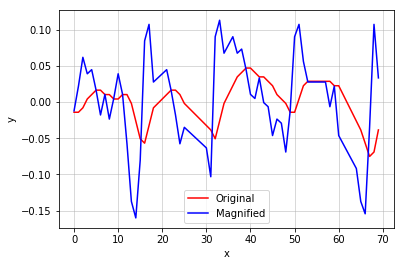

In [28]:
import matplotlib.pyplot as plt

plt.plot(CoM_or, color = 'red')
plt.plot(CoM_ma, color = 'blue')
plt.legend(('Original','Magnified'))
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.6)
plt.show

In [29]:
Obj = Magnificacion('pk3.mp4/', 'pk/')
Obj.CoMVisual(6)

(151, 2)
(150, 2)
tamaño de fotogramas (y, x, z): (270, 480, 3)


# Ejemplo de Centro de Masa:

In [15]:
def CentroDeMasa(img):
        
        from scipy import ndimage
        import numpy as np
        
        mass_center_tuple = ndimage.measurements.center_of_mass(img)
        
        if np.isnan(mass_center_tuple[0]) and np.isnan(mass_center_tuple[1]):

            mass_center = [0,0]
            
            return mass_center

        else:

            mass_center=[int(mass_center_tuple[0]),int(mass_center_tuple[1])]
            
            return mass_center

centro: 64;152


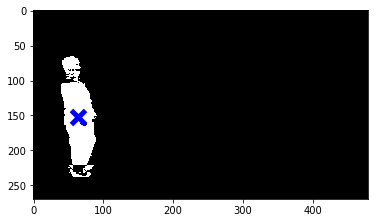

In [20]:
import cv2
import os
import matplotlib.pyplot as plt


center_of_mass = CentroDeMasa(cv2.imread('fotograma-059.png')) 
print 'centro: ' + str(center_of_mass[1]) + ';' + str(center_of_mass[0])
plt.scatter(center_of_mass[1],center_of_mass[0], marker="x", s=200, linewidth=5, c="b")
plt.imshow(cv2.imread('fotograma-059.png'))

# Prueba de Normalizar Media

<function matplotlib.pyplot.show>

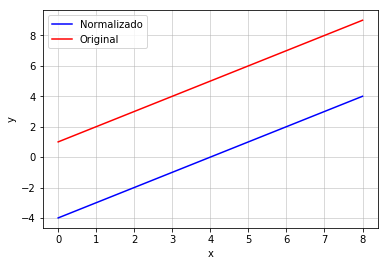

In [46]:
def NormaMedia(array):
        import numpy as np
        media = np.average(array)
        array = array - media
        return array

a = [1,2,3,4,5,6,7,8,9]    
array = NormaMedia(a)
    
import matplotlib.pyplot as plt

plt.plot(array, color = 'blue')
plt.plot(a, color = 'red')
plt.legend(('Normalizado','Original'))
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.6)
plt.show

# Prueba de Magnificacion

In [11]:
def Magnificar(y, x, alfa):
        
    
    x = alfa*x
    y = y*alfa
    return int(y), int(x)
        
        
Magnificar(0,2,4)

(0, 8)